# Lensing Background Galaxies by Foreground Halos

#### Spencer Everett, SLAC 7/29/2015

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import os,sys
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import cmath
import cPickle as pickle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
%matplotlib inline

In [3]:
# Pangloss:
PANGLOSS_DIR = os.path.expandvars("$PANGLOSS_DIR")
sys.path.append(PANGLOSS_DIR)
import pangloss

Import the convergence and shear maps:

In [4]:
K = pangloss.Kappamap(PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.kappa',FITS=False)

In [5]:
S = pangloss.Shearmap([PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_1',PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_2'],FITS=False)

Import the foreground galaxy catalog for the (0,0,0,0) field:

In [6]:
config = pangloss.Configuration(PANGLOSS_DIR+'/example/example.config')
F = pangloss.ForegroundCatalog(PANGLOSS_DIR+'/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt',config)

Generate a background galaxy catalog in the same field with 10 sources per square arcminute:

In [37]:
B = pangloss.BackgroundCatalog(N=0.05,sigma_e=0.01,field=[0,0,0,0])
B.lens_by_map(K,S)
B.galaxy_count

180

In [38]:
B.drill_lightcones(F=F,write=True)

In [39]:
infile = open(PANGLOSS_DIR+'/data/lightcones/lc_0_0_0_0.txt','rb')
lightcones = pickle.load(infile)
infile.close()

In [40]:
galaxy_counts = [lightcones[i].galaxy_count for i in range(len(lightcones))]
mean_galaxies = np.mean(galaxy_counts)
std_galaxies = np.std(galaxy_counts)
print mean_galaxies
print std_galaxies

882.311111111
119.947131358


In [41]:
B.lens_by_halos()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
average lightcone time:  0.733224468761
std lightcone time:  0.0125791863269


In [63]:
k_diff = abs((B.galaxies['kappa_halo']-B.galaxies['kappa'])/B.galaxies['kappa'])*100.0
k_diff_mean = np.mean(k_diff)
k_diff_std = np.std(k_diff)
print 'k_diff mean: ',k_diff_mean,'%'
print 'k_diff std: ',k_diff_std,'%'
print

g_diff = abs((B.galaxies['g_halo']-B.galaxies['g'])/B.galaxies['g'])*100.0
g_diff_mean = np.mean(g_diff)
g_diff_std = np.std(g_diff)
print 'g_diff mean: ',g_diff_mean,'%'
print 'g_diff std: ',g_diff_std,'%'
print

mod_diff = abs((B.galaxies['eMod_halo']-B.galaxies['eMod'])/B.galaxies['eMod'])*100.0
mod_diff_mean = np.mean(mod_diff)
mod_diff_std = np.std(mod_diff)
print 'mod_diff mean: ',mod_diff_mean,'%'
print 'mod_diff std: ',mod_diff_std,'%'
print

phi_diff = abs((B.galaxies['ePhi_halo']-B.galaxies['ePhi'])/B.galaxies['ePhi'])*100.0
phi_diff_mean = np.mean(phi_diff)
phi_diff_std = np.std(phi_diff)
print 'phi_diff mean: ',phi_diff_mean,'%'
print 'phi_diff std: ',phi_diff_std,'%'
print

print 'mean kappa: ',np.mean(B.galaxies['kappa'])
print 'mean kappa_halo: ',np.mean(B.galaxies['kappa_halo'])
print

print 'mean g: ',np.mean(B.galaxies['g'])
print 'mean g_halo: ',np.mean(B.galaxies['g_halo'])
print

print np.max(B.galaxies['g'])
print np.max(B.galaxies['g_halo'])

k_diff mean:  3115.49044029 %
k_diff std:  33415.6746649 %

g_diff mean:  154.088147509 %
g_diff std:  113.320049388 %

mod_diff mean:  77.559190952 %
mod_diff std:  167.23342321 %

phi_diff mean:  393.747538459 %
phi_diff std:  1644.95393419 %

mean kappa:  -0.00950995304958
mean kappa_halo:  0.037253925449

mean g:  (-0.0019270723007-0.00388696335483j)
mean g_halo:  (-0.000604683279805-0.00139370856602j)

(0.0480056659493+0.0320987848245j)
(0.110398446011-0.0158008528934j)


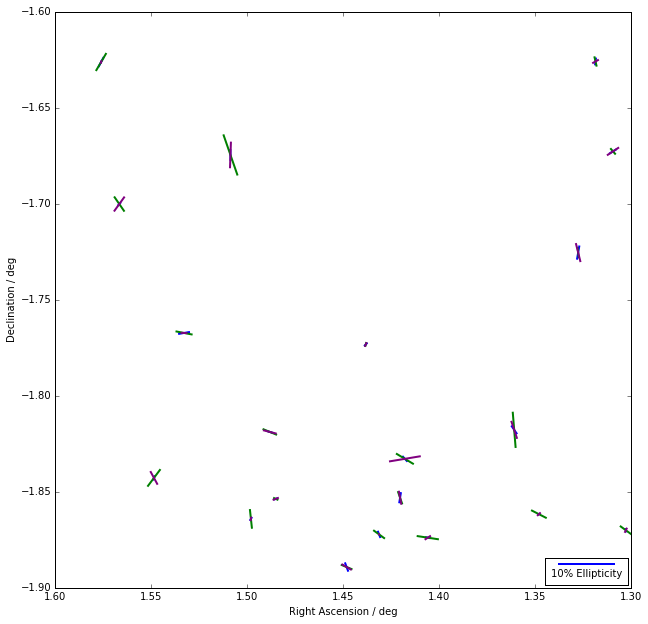

In [71]:
B.plot(subplot=[1.6,1.3,-1.9,-1.6],lensed='all',graph='stick')